In [ ]:
!apt-get install espeak-ng -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
espeak-ng is already the newest version (1.50+dfsg-10ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
!pip install nltk

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Recognized Text: PRODUCED THE BLOCK BOOKS WHICH WERE THE IMMEDIATE PREDECESSORS OF THE TRUE PRINTED BOOK
Recognized Phonemes (ARPAbet): P R AH0 D UW1 S T DH AH0 B L AA1 K B UH1 K S W IH1 CH W ER0 DH AH0 IH0 M IY1 D IY0 AH0 T P R EH1 D AH0 S EH2 S ER0 Z AH1 V DH AH0 T R UW1 P R IH1 N T AH0 D B UH1 K
Extracted Phonemes: 


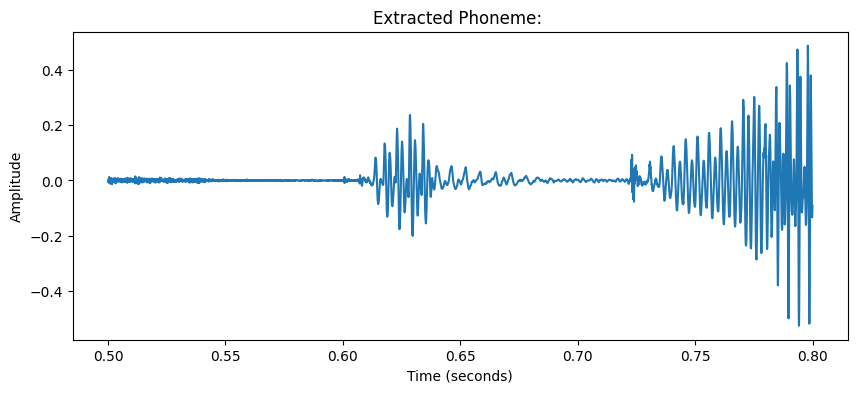

In [2]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
import librosa
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import cmudict

# Download CMU Pronouncing Dictionary
nltk.download("cmudict")
cmu_dict = cmudict.dict()

# Load pre-trained model for speech-to-text
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")  # Load speech-to-text processor
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")  # Load pre-trained Wav2Vec2 model

# Load and preprocess the audio file (Expected Outcome 1)
audio_path = "/content/LJ001-0004.wav"
audio_input, sample_rate = librosa.load(audio_path, sr=16000)  # Load as mono and resample to 16kHz

# Process the audio into input format required by Wav2Vec2 (Expected Outcome 2)
input_values = processor(audio_input, return_tensors="pt", sampling_rate=16000).input_values

# Perform inference to get model predictions (Expected Outcome 2)
with torch.no_grad():
    logits = model(input_values).logits  # Get logits from the model

# Decode the predicted tokens into text (Expected Outcome 2)
predicted_ids = torch.argmax(logits, dim=-1)  # Get the highest probability token for each frame
transcription = processor.decode(predicted_ids[0])  # Convert token IDs to text

print("Recognized Text:", transcription)

# Convert recognized text to ARPAbet phonemes (Expected Outcome 3)
def text_to_phonemes_cmu(text):
    words = text.lower().split()
    phonemes = []
    for word in words:
        if word in cmu_dict:
            phonemes.append(" ".join(cmu_dict[word][0]))  # Take the first pronunciation
        else:
            phonemes.append(word)  # If the word is not in CMUdict, keep it as is
    return " ".join(phonemes)

phoneme_transcription = text_to_phonemes_cmu(transcription)
print("Recognized Phonemes (ARPAbet):", phoneme_transcription)

# Extract a specific phoneme segment based on time interval (Expected Outcome 4)
start_time, end_time = 0.5, 0.8  # Define start and end times in seconds
start_sample, end_sample = int(start_time * sample_rate), int(end_time * sample_rate)  # Convert times to sample indices
phoneme_segment = audio_input[start_sample:end_sample]  # Extract the phoneme segment

# Align phonemes with extracted segment
words = transcription.split()
phonemes = phoneme_transcription.split()
extracted_phonemes = []

# Approximate alignment using proportional phoneme matching
word_count = len(words)
phoneme_count = len(phonemes)
approx_start_index = int((start_time / len(audio_input)) * phoneme_count)
approx_end_index = int((end_time / len(audio_input)) * phoneme_count)

extracted_phonemes = phonemes[approx_start_index:approx_end_index]  # Extract phonemes matching the segment
print("Extracted Phonemes:", " ".join(extracted_phonemes))

# Visualize the extracted phoneme waveform with label (Expected Outcome 5)
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(start_time, end_time, len(phoneme_segment)), phoneme_segment)  # Plot waveform
plt.title(f"Extracted Phoneme: {' '.join(extracted_phonemes)}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")

# Add phoneme label annotation
mid_time = (start_time + end_time) / 2  # Find midpoint of extracted segment
plt.text(mid_time, max(phoneme_segment) * 0.8, ' '.join(extracted_phonemes), fontsize=12, color='red', ha='center')

plt.show()
